In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input , Dropout , BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Initialize ImageDataGenerator with data augmentation
train_augmented_gen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill missing pixels
    validation_split=0.2   # Train/validation split
)

In [4]:
train_generator = train_augmented_gen.flow_from_directory(
    '../animals/', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_augmented_gen.flow_from_directory(
    '../animals/', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Important: Disable shuffling
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
model = Sequential([
    Input(shape=(150, 150, 3)),

    # First Convolutional Block with Regularization
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layers with Dropout
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # Drop 50% of neurons

    # Output Layer
    Dense(1, activation='sigmoid')
])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

In [10]:
# Initialize EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best model weights
)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=1500 // train_generator.batch_size,  # Use 1500 samples
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
25/46 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.5600 - loss: 1.7427

/home/mana-saleh/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.5554 - loss: 1.5867 - val_accuracy: 0.6146 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.6246 - loss: 0.9994 - val_accuracy: 0.6354 - val_loss: 0.8759 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.6693 - loss: 0.8254 - val_accuracy: 0.6510 - val_loss: 0.8350 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.6933 - loss: 0.7808 - val_accuracy: 0.7604 - val_loss: 0.7001 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.7433 - loss: 0.6965 - val_accuracy: 0.7969 - val_loss: 0.6339 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.7942 - loss: 0.6065 - val_accuracy: 0.8542 - val_loss: 0.5101 - learning_rate: 0.0010
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8292 - loss: 0.5507 - val_a

In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9912 - loss: 0.1432
Validation Accuracy: 99.00%
Validation Loss: 0.1406


In [14]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

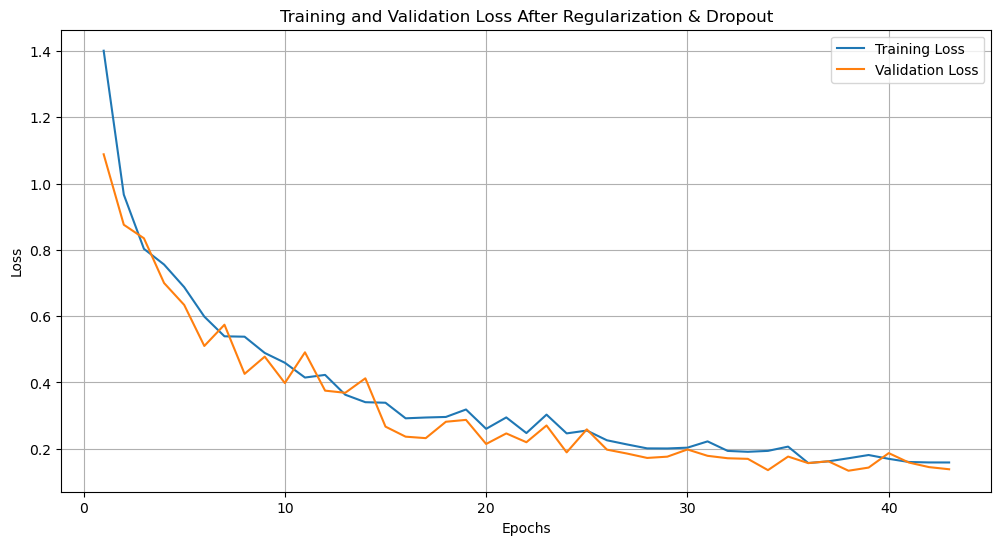

In [15]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title("Training and Validation Loss After Regularization & Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Get true labels and predictions
true_labels = validation_generator.classes
predictions = model.predict(validation_generator)
predicted_labels = np.round(predictions).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


In [17]:
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

In [18]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")

Accuracy: 97.50%
F1 Score: 0.9749


In [19]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Cat', 'Dog']))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.98      0.98       100
         Dog       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



In [20]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])

<Figure size 800x600 with 0 Axes>

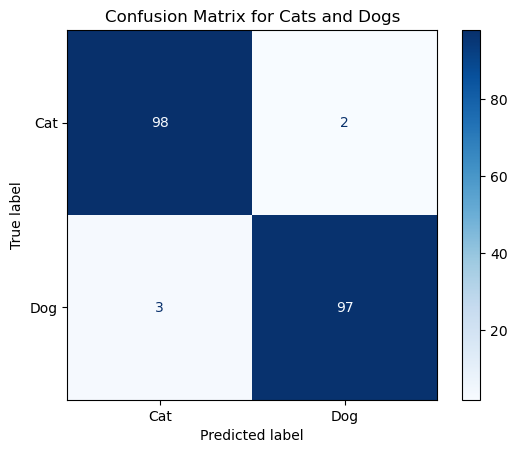

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Cats and Dogs")
plt.show();